In [146]:
import matplotlib.pyplot as plt
import numpy as np
from colossus.cosmology import cosmology
from colossus.lss import mass_function
from scipy import integrate
from astropy import constants as const
from astropy.cosmology import Planck15
import astropy.units as u
from astropy.io import fits
from matplotlib.ticker import FormatStrFormatter



In [23]:
def log_int(function, x0, xf, nstep = 1000):
    integral = 0
    domain = np.logspace(x0, xf, nstep)
    domain = np.log10(domain)
    for i in range(len(domain)-1): 
        #print(domain[i])
        #mtemp = (domain[i+1]-domain[i])/2
        #print(function(10**domain[i]))
        #print(mass_function.massFunction(10**domain[i], 0.15, mdef = '200m', model = 'tinker08', q_out = 'dndlnM'))
        integral += function(10**domain[i])*(domain[i+1] - domain[i])
    return integral

def zint(mass, zmin, zmax, nstep = 1000):
    z = np.linspace(zmin, zmax, nstep)
    
    integral = 0
    
    if mass > 100:
        #Shitty check if mass was given as just the exponant
        mass = np.log10(mass)

    for i in range(len(z)-1):
        ztemp = (z[i+1]+z[i])/2
        print(i, end = '\r')
        integrand = lambda m: mass_function.massFunction(m, ztemp, mdef = '200m', model = 'tinker08', q_out = 'dndlnM')
        integrated_density = log_int(integrand, 1, mass)
        #Comoving volume computed over full sky i.e. 4pi steradians. Scale accordingly
        comov_vol = Planck15.differential_comoving_volume(ztemp).value
        integral += integrated_density*comov_vol*(z[i+1]-z[i])
    return integral

cosmology.setCosmology('planck15')

print(zint(15, 0, 10, nstep = 100))

1.070657616414947e+19


In [12]:
num_density = mass_function.massFunction(14, .05, mdef = '200m', model = 'tinker08', q_out = 'dndlnM')
comov_vol = Planck15.comoving_volume(0.05).value

number = num_density * comov_vol

print(number)

2225695141019372.8


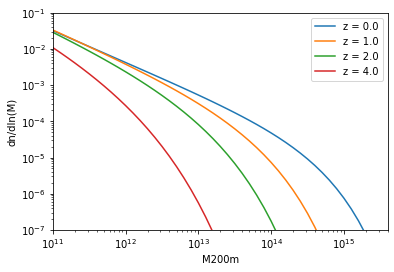

In [18]:
z = [0.0, 1.0, 2.0, 4.0]
M = 10**np.arange(11.0, 15.5, 0.1)

plt.figure()
plt.xlabel('M200m')
plt.ylabel('dn/dln(M)')
plt.loglog()
plt.xlim(1E11, 4E15)
plt.ylim(1E-7, 1E-1)
for i in range(len(z)):
    mfunc = mass_function.massFunction(M, z[i], mdef = '200m', model = 'tinker08', q_out = 'dndlnM')
    plt.plot(M, mfunc, '-', label = 'z = %.1f' % (z[i]))
plt.legend();

In [32]:
comov_vol = Planck15.comoving_volume(np.inf)
integrand = lambda m: mass_function.massFunction(10**m, 0, mdef = '200m', model = 'tinker08', q_out = 'dndlnM')
print(integrand(15))

7.559757678769526e-07


In [46]:
number = integrate.quad(integrand, 15, 20.5)

In [37]:
print(number[0]*Planck15.comoving_volume(np.inf).value)

1217602.2224881253


(None, None)

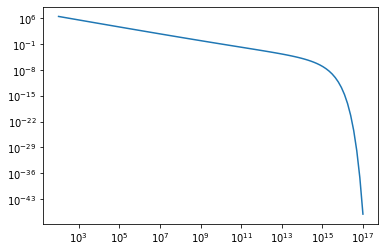

In [59]:
x0 = np.linspace(2, 17, 100)
y0 = np.zeros(len(x0))

for i in range(len(x0)):
    print(i, end = '\r')
    y0[i] = integrate.quad(integrand, x0[i], 20.5)[0]
plt.plot(10**x0, y0)
plt.xscale('log'), plt.yscale('log')

In [118]:
z0 = 0.05
dz = 0.05

dif_comov = lambda z: Planck15.differential_comoving_volume(z).value
mass_func = lambda m, z: mass_function.massFunction(10**m, z, mdef = '500m', model = 'tinker08', q_out = 'dndlnM')
def n_greater_m_at_z(M,z):
    #M must be in log
    if M > 25:
        M = np.log10(M)
    integrand = lambda m: mass_function.massFunction(10**m, z, mdef = '500m', model = 'tinker08', q_out = 'dndlnM')
    return integrate.quad(integrand, M, 20.5)[0]

def n_greater_m(M):
    zmin = 0.7
    zmax = 2
    
    survey_area = 17668*u.deg*u.deg
    
    survey_area = survey_area.to(u.sr)
    try:
        temp = np.zeros(len(M))
        for i in range(len(temp)):
            integrand = lambda z: Planck15.differential_comoving_volume(z).value*n_greater_m_at_z(M[i],z)*survey_area.value
            temp[i] = integrate.quad(integrand, zmin, zmax)[0]
    except:
        integrand = lambda z: Planck15.differential_comoving_volume(z).value*n_greater_m_at_z(M,z)*survey_area.value
        temp = integrate.quad(integrand, zmin, zmax)[0]
   
    
    
    return temp

In [123]:
print(n_greater_m(np.log10(1e14)))

54799.0389054919


In [93]:
d='/home/s/sievers/sdicker/ACTnCOWs/'
act=fits.open('/home/r/rbond/jorlo/dev/madcowsclusters/MADCOWSUnion_M500.fits')
mc=fits.open(d+'MADCOWSUnion.fits')
ACTnCOWS=fits.open('/home/r/rbond/jorlo/dev/madcowsclusters/ACTCOWS_matches_V04.fits')

richness = np.zeros(act[1].data[:]['name'].shape[0])
richness_e = np.zeros(act[1].data[:]['name'].shape[0])
mc_z=np.zeros(act[1].data[:]['name'].shape[0])
mc_m500=np.zeros(act[1].data[:]['name'].shape[0])
for ni,name in enumerate(act[1].data[:]['name']):
    ind=np.where(mc[1].data[:]['name'] == name)[0]
    if ind.shape[0] == 0:
        print('ERROR no match found for ',name) # should never get here...
    elif ind.shape[0] > 1:
        print('ERROR more than 1 match found for ',name)# should never get here
    else :
        richness[ni]=mc[1].data[ind[0]]['Rich']
        richness_e[ni]=mc[1].data[ind[0]]['e_Rich']
        mc_z[ni]=mc[1].data[ind[0]]['Photz']
        mc_m500[ni]=mc[1].data[ind[0]]['M500']
print('Done cutting data')

Done cutting data


In [100]:
carma_fit = lambda x: 10.**(1.65*np.log10(x) + -2.16)

richness.sort()

richness = richness[(0 < richness) & (richness < 200)]

masses = carma_fit(richness)

print(masses)
print(n_greater_m(np.log10(10.97e14)))

[ 0.02171198  0.0423887   0.06813951  0.06813951  0.09846922  0.13302999
  0.13302999  0.13302999  0.13302999  0.13302999  0.13302999  0.13302999
  0.17155831  0.21384469  0.21384469  0.21384469  0.25971686  0.25971686
  0.25971686  0.25971686  0.25971686  0.25971686  0.30902954  0.30902954
  0.30902954  0.30902954  0.30902954  0.30902954  0.36165788  0.36165788
  0.36165788  0.36165788  0.36165788  0.36165788  0.36165788  0.36165788
  0.41749286  0.41749286  0.41749286  0.41749286  0.41749286  0.41749286
  0.41749286  0.41749286  0.41749286  0.41749286  0.41749286  0.41749286
  0.47643815  0.47643815  0.47643815  0.47643815  0.47643815  0.47643815
  0.47643815  0.47643815  0.47643815  0.47643815  0.47643815  0.47643815
  0.47643815  0.47643815  0.5384077   0.5384077   0.5384077   0.5384077
  0.5384077   0.5384077   0.5384077   0.5384077   0.5384077   0.5384077
  0.5384077   0.60332397  0.60332397  0.60332397  0.60332397  0.60332397
  0.60332397  0.60332397  0.60332397  0.60332397  0.6

1.1278405874730943


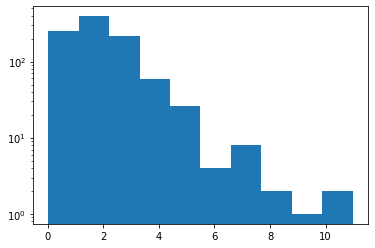

In [126]:
bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]

binned_num = np.zeros(len(bins))
for i, mass in enumerate(bins):
    binned_num[i] = len(masses[(mass-0.5 < masses) & (masses < mass+0.5)])
#Account for the nearly 11e14 mass
binned_num[-1] += binned_num[-1] 

#x0 = np.linspace(np.log10(1e14), np.log10(10e14), num = 100)

plt.hist(masses, bins = 10)
#plt.plot(x0, n_greater_m(np.log10(x0)))
plt.yscale('log')

In [127]:
print(binned_num)

[214. 406. 201.  84.  37.  11.   6.   2.   2.   2.]


In [130]:
ebins = [np.log10(mass*1e14) for mass in bins]

In [131]:
print(ebins)

[13.698970004336019, 14.176091259055681, 14.397940008672037, 14.544068044350276, 14.653212513775344, 14.740362689494244, 14.812913356642856, 14.8750612633917, 14.929418925714293, 14.977723605288848]


In [136]:
mass_func = n_greater_m(ebins)

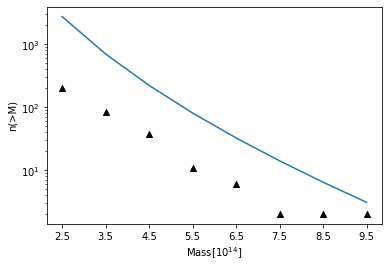

In [161]:
cut = 2

x = [10**mass for mass in ebins[cut:]]

fig, ax = plt.subplots()

plt.scatter(x, binned_num[cut:], marker = '^', color = 'black', label = 'MaDCoWS Data')
plt.plot(x, mass_func[cut:], label = 'Tinker08 Model')
plt.xticks(x, labels = bins[cut:])

plt.yscale('log')
plt.xlabel(r'Mass[$10^{14}$]')
plt.ylabel(r'n(>M)')
#ax.xaxis.set_major_formatter(FormatStrFormatter('%.0e'))
plt.savefig('massfunc.pdf')